# Projet : Extraction et Recommandation de films et séries avec rdflib et SPARQL

## Objectif
L’objectif de ce mini-projet est l’extraction des données de la base de données DBPedia en utilisant le langage de requêtes SPARQL afin d'alimenter la base de données de séries que vous avez créé au premier TP, l’analyse de ces données et la recommandation de séries et de films.

# Description

Vous allez créer un système de recommandation de séries/films basé sur des données RDF qui stockent des informations sur les films, les utilisateurs et leurs préférences cinématographiques.

Les étapes du projet sont comme suit :

## 1.  Extraction des données

a)  Vous utiliserez Rdflib pour accéder aux données et vous effectuerez des requêtes SPARQL pour les extraire. Vous êtes libres dans le choix et la taille des données que vous allez extraire. Le jeu de données doit néanmoins être représentatif pour pouvoir fournir des recommandations précises. 
    
   - Les données à extraire : 
       - Films : Chaque film a un titre, un réalisateur, une année de sortie, un genre (e.g. : action, comédie, science-fiction), un résumé, une liste d'acteurs principaux, une durée, une évaluation du film, etc.
       - Réalisateur : Chaque réalisateur a un nom, une biographie et une liste de films qu'il a réalisés.
       - Acteurs : Chaque acteur a un nom, une biographie et une liste de films dans lesquels il a joué.
       - Genres :  Chaque genre a un nom et une description.
       - Utilisateurs : chaque utilisateur a un identifiant et des préférences cinématographiques (acteurs préférés, genres préférés, etc).
       - Évaluations : Elle est décrite par l'identifiant de l'utilisateur qui a donné l'évaluation, identifiant du film évalué la note attribuée au film, Commentaire ou avis sur le film.

   - Liens entre les entités : 

        - Les films sont associés à leurs acteurs, réalisateurs et genres.
        - Les utilisateurs sont associés aux films qu'ils ont évalués.
        - Les utilisateurs peuvent être liés entre eux en fonction de leurs préférences cinématographiques similaires.

   b)  Transformer les données en triplets RDF :  Vous allez transformer ces résultats en triplets RDF avant de les ajouter à votre graphe RDF existant. 
  
  c) Ajouter les données au graphe existant : Utilisez la méthode g.add() de votre graphe RDF, que vous avez créé au premier TP, pour ajouter les triplets RDF représentant les données DBpedia que vous avez transformées. 

In [24]:
from SPARQLWrapper import SPARQLWrapper, JSON
from rdflib import Graph, URIRef, Literal, Namespace
from rdflib.namespace import RDF, RDFS
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Step 1: Extract data from SPARQL endpoint using SPARQLWrapper
def extract_data_sparql(endpoint, query):
    """
    Extract data from a SPARQL endpoint.

    Parameters:
        endpoint (str): The SPARQL endpoint URL.
        query (str): The SPARQL query to execute.

    Returns:
        list: Results in JSON format from the SPARQL query.
    """
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    return results["results"]["bindings"]

# Example SPARQL Query
film_query = """
SELECT ?film ?title ?genre ?director ?releaseDate ?actor
WHERE {
  ?film rdf:type dbo:Film.
  ?film rdfs:label ?title.
  OPTIONAL { ?film dbo:genre ?genre. }
  OPTIONAL { ?film dbo:director ?director. }
  OPTIONAL { ?film dbo:releaseDate ?releaseDate. }
  OPTIONAL { ?film dbo:starring ?actor. }
  FILTER (lang(?title) = 'en').
}
LIMIT 10000
"""

# Extract data from the endpoint
endpoint = "http://dbpedia.org/sparql"
data = extract_data_sparql(endpoint, film_query)

# Step 1b: Transform the data into RDF triples
RDF_NAMESPACE = Namespace("http://example.org/film#")
graph = Graph()
graph.bind("film", RDF_NAMESPACE)

# Populate the graph with data from SPARQL query
for row in data:
    film = URIRef(row["film"]["value"])
    # Add film title to the graph
    title = row["title"]["value"].strip()
    if title:
        graph.add((film, RDFS.label, Literal(title)))

    # Add genre if available and valid
    if "genre" in row and row["genre"].get("value"):
        genre_value = row["genre"]["value"].strip()
        if genre_value:
            graph.add((film, RDF_NAMESPACE.genre, URIRef(genre_value)))

    # Add director if available and valid
    if "director" in row and row["director"].get("value"):
        director_value = row["director"]["value"].strip()
        if director_value:
            graph.add((film, RDF_NAMESPACE.director, URIRef(director_value)))

    # Add release date if available and valid
    if "releaseDate" in row and row["releaseDate"].get("value"):
        release_date_value = row["releaseDate"]["value"].strip()
        if release_date_value:
            graph.add((film, RDF_NAMESPACE.releaseDate, Literal(release_date_value)))

    # Add actor if available and valid
    if "actor" in row and row["actor"].get("value"):
        actor_value = row["actor"]["value"].strip()
        if actor_value:
            graph.add((film, RDF_NAMESPACE.actor, URIRef(actor_value)))

# Save the graph to an RDF file
output_file = "graph_data.rdf"
graph.serialize(destination=output_file, format="xml")
print(f"Graph saved to {output_file}")




Graph saved to graph_data.rdf


## 2. Prétraitement des données   

Nettoyez et traitez les données extraites pour supprimer les doublons, gérer les valeurs manquantes et normaliser.

In [25]:
# Step 2: Preprocess the RDF graph
def preprocess_data(graph):
    """
    Clean and normalize the RDF graph by removing duplicates, handling missing values, and normalizing literals.

    Parameters:
        graph (Graph): The RDF graph to clean.

    Returns:
        Graph: The cleaned RDF graph.
    """
    cleaned_graph = Graph()
    for s, p, o in graph:
        # Skip triples with missing or empty literals
        if isinstance(o, Literal) and not str(o).strip():
            continue
        # Normalize literals to lowercase for uniformity
        if isinstance(o, Literal):
            o = Literal(str(o).strip().lower())
        # Add unique triples to the cleaned graph
        if (s, p, o) not in cleaned_graph:
            cleaned_graph.add((s, p, o))
    return cleaned_graph

graph = preprocess_data(graph)

## 3. Analyse exploratoire des données 

- Créer des graphiques permettant de visualiser la distribution des films et séries dans votre base de données.
- Créer un graphique pour montrer les films et les séries les mieux notés
- Créer un nuage de points pour représenter la relation entre les caractéristiques

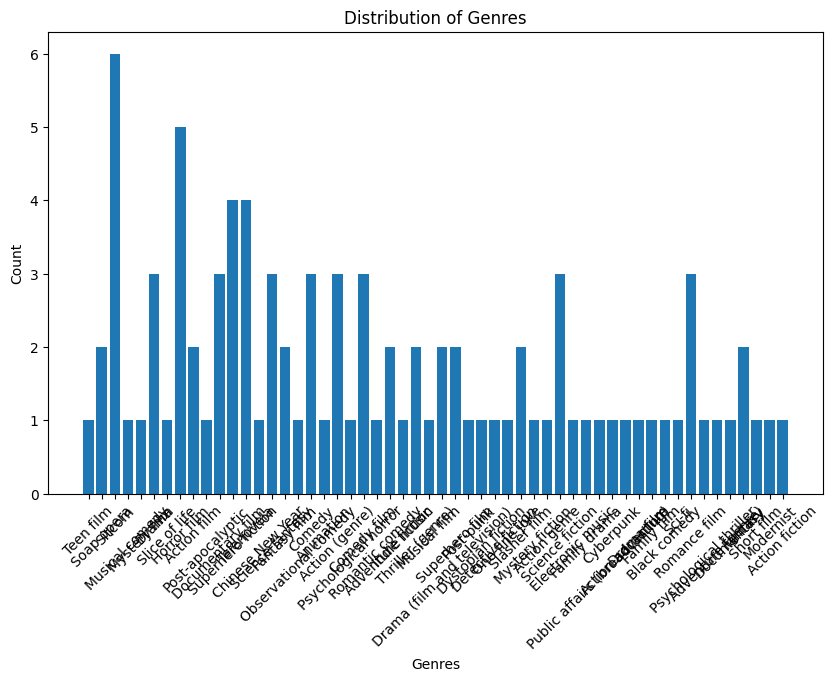

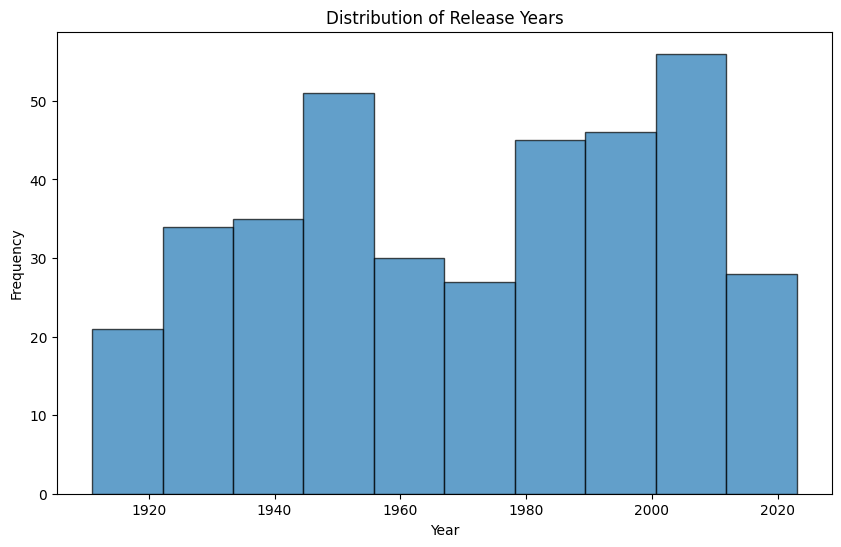

c:\Users\niman\OneDrive\Desktop\Web_sem\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65119 (\N{SMALL NUMBER SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


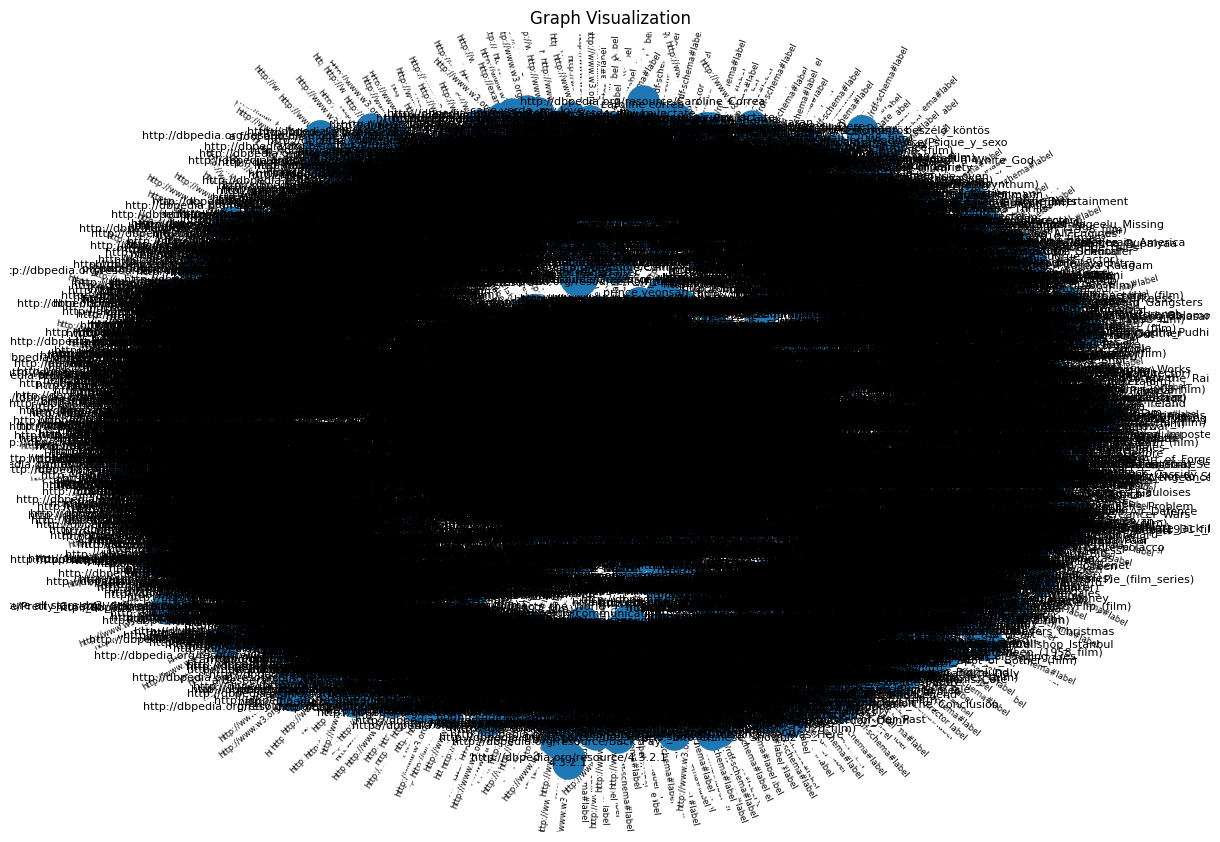

                                   Label              Director  \
0               Power Rangers Time Force      Isaac_Florentine   
1     Captain America II: Death Too Soon  Ivan_Nagy_(director)   
2                        Páginas da Vida       Jayme_Monjardim   
3  Caravan of Courage: An Ewok Adventure            John_Korty   
4                 Princesses (TV series)    Lee_Shallat-Chemel   

                                              Actors  \
0  [Vernon_Wells_(actor), Edward_Albert, Michael_...   
1                                        [Reb_Brown]   
2  [José_Mayer, Regiane_Alves, Regina_Duarte, Líl...   
3  [Eric_Walker_(entertainer), Warwick_Davis, Fio...   
4             [Julie_Hagerty, Twiggy, Fran_Drescher]   

                                              Genres  
0  [Superhero_fiction, Action_(genre), Science_fi...  
1     [Superhero_film, Action_film, Science_fiction]  
2          [Telenovela, Slice_of_life, Family_drama]  
3                                     [Fantasy

In [26]:

# Step 3: Exploratory Data Analysis
def visualize_data(graph):
    """
    Create bar and histogram visualizations for genres and release dates.

    Parameters:
        graph (Graph): The RDF graph.
    """
    # Count the number of movies per genre
    genres = {}
    for s, p, o in graph.triples((None, RDF_NAMESPACE.genre, None)):
        genres[o] = genres.get(o, 0) + 1

    # Normalize genre names for visualization
    genres_normalized = {str(k).split("/")[-1].replace("_", " "): v for k, v in genres.items()}

    # Bar plot for genres
    plt.figure(figsize=(10, 6))
    if genres:
        plt.bar(genres_normalized.keys(), genres_normalized.values())
        plt.title("Distribution of Genres")
        plt.xlabel("Genres")
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.show()
    else:
        print("No genres available to visualize.")

    # Histogram for release years
    release_years = []
    for s, p, o in graph.triples((None, RDF_NAMESPACE.releaseDate, None)):
        try:
            year = int(str(o).split("-")[0])  # Extract the year
            release_years.append(year)
        except ValueError:
            continue

    if release_years:
        plt.figure(figsize=(10, 6))
        plt.hist(release_years, bins=10, alpha=0.7, edgecolor="black")
        plt.title("Distribution of Release Years")
        plt.xlabel("Year")
        plt.ylabel("Frequency")
        plt.show()
    else:
        print("No valid release years found to visualize.")

visualize_data(graph)

# Step 3b: Visualize Graph with NetworkX
def visualize_graph(graph):
    """
    Visualize the RDF graph using NetworkX.

    Parameters:
        graph (Graph): The RDF graph.
    """
    nx_graph = nx.Graph()

    for s, p, o in graph:
        nx_graph.add_edge(str(s), str(o), label=str(p))

    if nx_graph.number_of_nodes() > 0:
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(nx_graph)
        nx.draw(nx_graph, pos, with_labels=True, node_size=500, font_size=8)
        edge_labels = nx.get_edge_attributes(nx_graph, 'label')
        nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels, font_size=6)
        plt.title("Graph Visualization")
        plt.show()
    else:
        print("No data in graph to visualize.")

visualize_graph(graph)

# Step 4: Load RDF data into the graph
def load_rdf_data(file_path, rdf_format="xml"):
    """
    Load RDF data from a file into an RDFLib graph.

    Parameters:
        file_path (str): Path to the RDF file.
        rdf_format (str): Format of the RDF file (default is "xml").

    Returns:
        Graph: An RDFLib graph containing the data.
    """
    graph = Graph()
    graph.parse(file_path, format=rdf_format)
    return graph

# Step 5: Extract film data manually
def extract_film_data(graph):
    """
    Extract film data from an RDF graph.

    Parameters:
        graph (Graph): The RDF graph containing film data.

    Returns:
        list: A list of dictionaries representing films and their properties.
    """
    film_data = []
    for s, p, o in graph:
        if p == RDFS.label:
            film = {"Label": str(o)}
            # Fetch related properties for the film subject
            for ss, pp, oo in graph.triples((s, None, None)):
                if pp == URIRef("http://example.org/film#director"):
                    film["Director"] = str(oo).split("/")[-1]
                elif pp == URIRef("http://example.org/film#genre"):
                    film.setdefault("Genres", []).append(str(oo).split("/")[-1])
                elif pp == URIRef("http://example.org/film#actor"):
                    film.setdefault("Actors", []).append(str(oo).split("/")[-1])
            film_data.append(film)
    return film_data

# Step 6: Convert to DataFrame for visualization
def create_film_dataframe(film_data):
    """
    Create a pandas DataFrame from a list of film dictionaries.

    Parameters:
        film_data (list): List of dictionaries containing film data.

    Returns:
        DataFrame: A pandas DataFrame containing the film data.
    """
    return pd.DataFrame(film_data)

# Step 7: Clean the DataFrame to remove null values
def clean_dataframe(df):
    """
    Remove rows with null or missing values from the DataFrame.

    Parameters:
        df (DataFrame): The DataFrame to clean.

    Returns:
        DataFrame: The cleaned DataFrame.
    """
    # Drop rows with any null or missing values
    df = df.dropna()

    # Reset index for cleaned DataFrame
    df = df.reset_index(drop=True)

    return df

# Load RDF data
graph = load_rdf_data("graph_data.rdf")

# Extract and process film data
film_data = extract_film_data(graph)
df_film_data = create_film_dataframe(film_data)

# Clean the DataFrame
df_film_data = clean_dataframe(df_film_data)

# Step 8: Display the cleaned DataFrame
print(df_film_data.head())


## 4. Système de Recommandation 

a) Utiliser SPARQL pour interroger le graphe RDF afin de créer un système de recommandation de films et/ou séries. Vous pouvez envisager différentes approches de recommandation, telles que la recommandation collaborative (en fonction des évaluations d'utilisateurs similaires) ou la recommandation basée sur le contenu (en fonction des genres, des acteurs, etc.) ou la recommandation basée sur les connaissances

b) Utiliser une IA (ChatGPT ou tout autre) pour répondre à cette question

In [27]:
df_film_data


,Label,Director,Actors,Genres
0,Power Rangers Time Force,Isaac_Florentine,"[Vernon_Wells_(actor), Edward_Albert, Michael_...","[Superhero_fiction, Action_(genre), Science_fi..."
1,Captain America II: Death Too Soon,Ivan_Nagy_(director),[Reb_Brown],"[Superhero_film, Action_film, Science_fiction]"
2,Páginas da Vida,Jayme_Monjardim,"[José_Mayer, Regiane_Alves, Regina_Duarte, Líl...","[Telenovela, Slice_of_life, Family_drama]"
3,Caravan of Courage: An Ewok Adventure,John_Korty,"[Eric_Walker_(entertainer), Warwick_Davis, Fio...",[Fantasy_film]
4,Princesses (TV series),Lee_Shallat-Chemel,"[Julie_Hagerty, Twiggy, Fran_Drescher]",[Sitcom]
5,Power Rangers Mystic Force,John_Laing_(director),"[John_Tui, Richard_Brancatisano, Melanie_Valle...","[Superhero_fiction, Action_fiction, Adventure_..."
6,Campus (TV series),Victoria_Pile,"[Sara_Pascoe, Jonathan_Bailey, Joseph_Millson,...",[Sitcom]
7,Captain Barbell (2011 TV series),Dominic_Zapata,[Richard_Gutierrez],"[Action_genre, Drama_(film_and_television), Fa..."
8,Cage Without a Key,Buzz_Kulik,"[Sam_Bottoms, Anne_Bloom, Katherine_Helmond, L...",[Drama_(film_and_television)]
9,Puff the Magic Dragon in the Land of the Livin...,Charles_Swenson,"[Robert_Ridgely, Peter_Yarrow, Burgess_Meredit...","[Short_film, Family_film, Animation, Fantasy]"


## 5. Calcul des Recommandations 

a) Utiliser SPARQL pour générer des requêtes de recommandation en fonction des préférences de l'utilisateur. Vous pouvez également utiliser des algorithmes d'apprentissage automatique pour améliorer les recommandations.

b) Utiliser une IA pour répondre à cette question

In [31]:
# Step 8: Machine Learning-based Recommendation System
def recommend_with_ml(df, user_prefs, top_n=10):
    """
    Recommend films using a machine learning approach with TF-IDF and cosine similarity.

    Parameters:
        df (DataFrame): The film data DataFrame.
        user_prefs (dict): User preferences containing 'genres', 'directors', 'actors'.
        top_n (int): Number of recommendations to return.

    Returns:
        DataFrame: Top recommended films with similarity scores.
    """
    # Combine user preferences into a single text
    user_genres = " ".join(user_prefs.get("genres", [])).lower()
    user_directors = " ".join(user_prefs.get("directors", [])).lower()
    user_actors = " ".join(user_prefs.get("actors", [])).lower()
    user_profile = f"{user_genres} {user_directors} {user_actors}"

    # Combine film attributes into a single text column
    df["Combined"] = (
        df["Genres"].apply(lambda x: " ".join(x) if isinstance(x, list) else "")
        + " "
        + df["Director"].fillna("")
        + " "
        + df["Actors"].apply(lambda x: " ".join(x) if isinstance(x, list) else "")
    ).str.lower()

    # Vectorize the combined text using TF-IDF
    vectorizer = TfidfVectorizer()
    film_vectors = vectorizer.fit_transform(df["Combined"])
    user_vector = vectorizer.transform([user_profile])

    # Compute cosine similarity between user profile and film vectors
    similarity_scores = cosine_similarity(user_vector, film_vectors).flatten()

    # Add similarity scores to the DataFrame
    df["Similarity"] = similarity_scores

    # Sort by similarity scores and return the top recommendations
    recommendations = df.sort_values(by="Similarity", ascending=False).head(top_n)
    return recommendations[["Label", "Similarity"]]

## 6. Évaluation  

a) Évaluez la qualité de vos recommandations en utilisant des mesures telles que  MAP@k (Mean Average Precision at k) ou NDCG@k (Normalized Discounted Cumulative Gain at k)

b) Comparer les recommandations que vous avez obtenues par rapport à celles générées par l'IA que vous aurez utilisée

In [33]:
# Step 9: Evaluate Recommendations
def evaluate_recommendations(user_prefs, recommendations, k=10):
    """
    Evaluate recommendations using MAP@k and NDCG@k.

    Parameters:
        user_prefs (dict): User preferences containing ground truth films.
        recommendations (DataFrame): Recommended items with similarity scores.
        k (int): Number of top recommendations to evaluate.

    Returns:
        dict: A dictionary containing MAP@k and NDCG@k scores.
    """
    # Extract top-k recommendations
    recommended_items = recommendations["Label"].head(k).tolist()

    # Use user preferences as ground truth
    ground_truth = user_prefs.get("favorite_films", [])

    # Calculate relevance vector
    relevance = [1 if item in ground_truth else 0 for item in recommended_items]

    # MAP@k: Mean Average Precision at k
    precision_at_k = 0
    relevant_items_found = 0
    for i, is_relevant in enumerate(relevance):
        if is_relevant:
            relevant_items_found += 1
            precision_at_k += relevant_items_found / (i + 1)
    map_k = precision_at_k / min(len(ground_truth), k) if ground_truth else 0

    # NDCG@k: Normalized Discounted Cumulative Gain at k
    ndcg_k = ndcg_score([relevance], [relevance], k=k) if relevance else 0

    return {"MAP@k": map_k, "NDCG@k": ndcg_k}

# Load RDF data
graph = load_rdf_data("graph_data.rdf")

# Extract and process film data
film_data = extract_film_data(graph)
df_film_data = create_film_dataframe(film_data)

# Clean the DataFrame
df_film_data = clean_dataframe(df_film_data)

# Example usage for ML-based recommendations
user_prefs = {
    "genres": ["comedy", "horror", "Sitcom"],
    "directors": ["spielberg", "atom_egoyan", "Peter_Werner"],
    "actors": ["tom_hanks", "sandra_bullock"],
    "favorite_films": ["Pulp Fiction", "The Godfather", "Inception"]
}

ml_recommendations = recommend_with_ml(df_film_data, user_prefs, top_n=10)
print(ml_recommendations)

# Evaluate recommendations
evaluation_scores = evaluate_recommendations(user_prefs, ml_recommendations, k=10)
print("Evaluation Scores:", evaluation_scores)


                                    Label  Similarity
24                             CarniK Con    0.235621
26                             Cars Toons    0.214315
11                          Call Me Claus    0.208253
4                  Princesses (TV series)    0.155659
23                            Camp Wilder    0.118724
6                      Campus (TV series)    0.109601
22                            Psychoville    0.097358
5              Power Rangers Mystic Force    0.000000
3   Caravan of Courage: An Ewok Adventure    0.000000
2                         Páginas da Vida    0.000000
Evaluation Scores: {'MAP@k': 0.0, 'NDCG@k': np.float64(0.0)}


## 7. Rapport 

Vous allez rédiger un rapport de 5 pages max décrivant la modélisation RDF, les requêtes SPARQL, l'algorithme de recommandation et les résultats de l'évaluation. Vous spécifierez votre utilisation de l'IA dans le cadre de ce projet et ce que vous en pensez